<h1>Part 1 - Objective, Methodology, End-to-End Demonstration</h1>

<h2>Motivation & Objective: Study Chess Positions with Less Friction</h2>

<li><b>Motivation</b>: Watching YouTube: "But why not <i>insert_random_chess_move</i>??" The video moves on without hearing you... In a parallel universe, the video still doesn't hear you but you open that position on a chess engine...
    
<li><b>Objective</b> is to facilitate the study of a chess position by transferring the piece placement from a screenshot into a chess engine. The project will make available "what-if" scenarios for a real-time interactive position exploration. 

<li>The project will capture the piece placement of an online chess game from a screen capture. Screenshot -> FEN.

<li>The end-to-end demonstration below will use a screenshot file as an input and output the board state in form of an FEN.

My hope is that it will help chess enthusiasts to analyze chess positions 

Methodology is described next.

<h2>Methodology + Implementation Classes + Contribution</h2>

My **methodology** to approach the piece placement problem is to divide it into sub-problems that are solved one after another. In this implementation the sub-problems are ordered as follows:<ol>
    <li>Board Detection (Neural Net) </li>
    <li>Board Extraction and Splitting into Squares </li>
    <li>Square Classification (Neural Net) </li>
    <li>Combination of Squares and Creation of FEN Piece Placement</li> </ol>
    <br>
    
The **implementation** has two main classes and a utility module: <ol>
    <li> Board_Detection(): A labeler, trainer and a detector for creating bounding box proposals for chessboards in a screenshot. Labeler is implemented in gcb_utils using tkinter while trainer and detector are interfaces into PyTorch implementation of Yolov5 (https://github.com/ultralytics/yolov5, see https://pjreddie.com/media/files/papers/yolo.pdf for Yolo.)   
        Main methods are update_labels, train and predict.
    <li> Piece_Classification(): A labeler, trainer and a detector for classifying piece content of a square. Labeler is implemented in gcb_utils using tkinter while trainer and detector are simple fully connected neural networks created implemented in Tensorflow.   
        Main methods are update_labels, train and predict.
    <li> gcb_utils: Implements labeling GUIs; chessboard extraction, manipulation and splitting; and FEN piece placement string creation. </ol>
    <br>
Technical **contributions** of the Project: <ol>
    <li> End-to-end neural-network based piece placement generation from a screenshot.
    <li> Transfer learning from an object detection model trained on COCO dataset (yolov5 on PyTorch)
    <li> Bottom up training of a fully connected classifier (Tensorflow)
    <li> Creation of chess-specific and almost platform-independent tkinter-based labeling tools for board labeling and square identification. Tkinter is available on most Unix platforms, macOS and Windows. </ol>
        
        

<br>Now, let's step through the methodology to run through an end-to-end detection path.
      

In [1]:
#import packages
from board_detection import Board_Detection
import gcb_utils.gcb_utils as gcb_utils
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from piece_classification import Piece_Classification
from PIL import Image
import shutil
import tensorflow as tf
import tensorflow_addons as tfa
%matplotlib inline

<h2>End-to-End Demonstration </h2>

Demonstration will consist of the following stages:
1.  Board Detection
2.  Board to Squares
3.  Piece Classification
4.  FEN with Piece Placement


<h3> 1. Board Detection</h3>

Let's first move the image to a temporary detection directory and view the image.

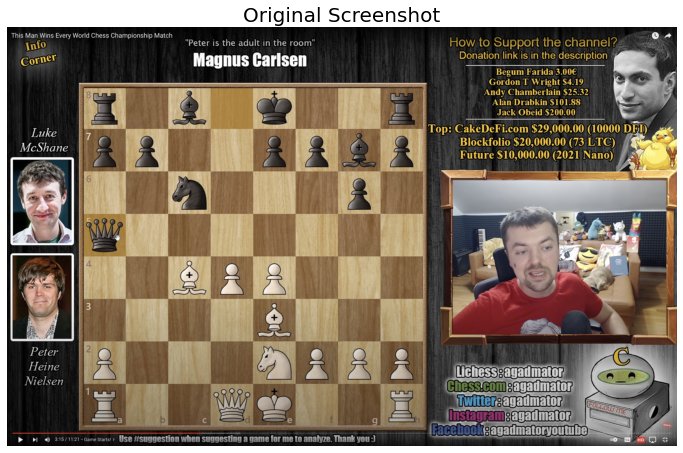

In [12]:
file_dir = 'demo_screenshots'
file_fname = 'Screen Shot 2021-12-18 at 7.22.11 AM.png'
file_full_path = os.path.join(file_dir, file_fname)

#Create a temporary directory structure for demonstration work; Clean up files before demonstration run.
#Demonstration will populate all directories below.
demo_dirs = ['TMP', 'TMP/_SCR_IMAGE', 'TMP/_DETECTBOARD', 'TMP/_DETECTBOARD/labels', 'TMP/_BOARD_IMAGE', 'TMP/_SQ_IMAGES']
for _dir in demo_dirs:
    if not os.path.exists(_dir):
        os.mkdir(_dir)
    else:
        for _file in os.listdir(_dir):
            _f = os.path.join(_dir,_file)
            if os.path.isfile(_f):
                os.remove(_f)    

tmp_scr_image_dir = 'TMP/_SCR_IMAGE'
tmp_full_path = os.path.join(tmp_scr_image_dir, file_fname)

_im = Image.open(file_full_path)
_im = _im.resize(gcb_utils.get_new_im_size(*_im.size, 1440, 1440)) 
_im.save(tmp_full_path)

plt.imshow(_im)
plt.gca().set_axis_off()
plt.gca().set_title('Original Screenshot', fontsize=20)
plt.gcf().set_size_inches(12,8)
plt.show()

In [3]:
board_model_dir = 'data/model/board-final_weight'
board_model_weight_fname = 'board_best.pt' 
source_dir =  tmp_scr_image_dir
imgsz = (1440, 1440) #Square shape image size 
project_dir = 'TMP'
project_name = '_DETECTBOARD'
conf_thres = 0.10

board_detector = Board_Detection(board_model_dir, board_model_weight_fname)
prediction = board_detector.predict(board_model_dir, 
                                    board_model_weight_fname, 
                                    source_dir, 
                                    imgsz, 
                                    project_dir, 
                                    project_name,  
                                    exist_ok = True, 
                                    conf_thres = conf_thres,
                                    save_txt = True, 
                                    save_conf = True)

print('DataFrame for predicted bounded boxes is below: ("norm": position is normalized to be between 0 and 1.)')
prediction

YOLOv5 🚀 v6.0-114-ga4207a2 torch 1.9.0 CPU

Fusing layers... 
Model Summary: 213 layers, 7012822 parameters, 0 gradients


image 1/1 /Users/artun/Desktop/Springboard/springboard/Get-Chess-Board/TMP/_SCR_IMAGE/Screen Shot 2021-12-18 at 7.22.11 AM.png: 928x1440 1 Chessboard, Done. (0.506s)
Speed: 2.3ms pre-process, 505.5ms inference, 0.6ms NMS per image at shape (1, 3, 1440, 1440)
Results saved to TMP/_DETECTBOARD
1 labels saved to TMP/_DETECTBOARD/labels


yolov5 detection results are saved in: /Users/artun/Desktop/Springboard/springboard/Get-Chess-Board/TMP/_DETECTBOARD
DataFrame for predicted bounded boxes is below: ("norm": position is normalized to be between 0 and 1.)


,fname,label,confidence,x_min_norm,x_max_norm,y_min_norm,y_max_norm
0,Screen Shot 2021-12-18 at 7.22.11 AM,0,0.944209,0.115972,0.626389,0.136667,0.961111


Now, let's pick up the largest board from above (only one here), save it and display. Choosing the largest board is for demonstration purposes.

Board Width and Height: (1470, 1483)


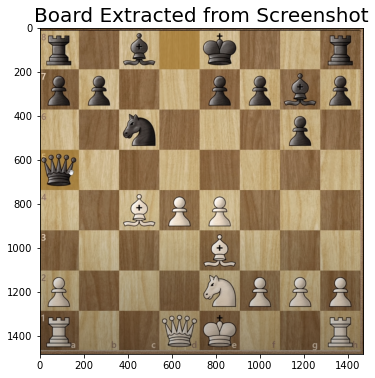

In [4]:
board_idx = ((prediction['x_max_norm']-prediction['x_min_norm'])*(prediction['y_max_norm']-prediction['y_min_norm'])).argmax()

board_fname = ''.join(file_fname.split('.')[:-1]) + '_brd' + '.' + file_fname.split('.')[-1]

_im = Image.open(file_full_path)

left_x_min = int(prediction.loc[board_idx, 'x_min_norm']*_im.width)
right_x_max = int(prediction.loc[board_idx, 'x_max_norm']*_im.width)
lower_y_max = int(prediction.loc[board_idx, 'y_max_norm']*_im.height)
upper_y_min = int(prediction.loc[board_idx, 'y_min_norm']*_im.height)

_im = _im.crop(box = (left_x_min, upper_y_min, right_x_max, lower_y_max))

board_path = 'TMP/_BOARD_IMAGE'
_im.save(os.path.join(board_path, board_fname))
print("Board Width and Height: ({0}, {1})".format(_im.width, _im.height))

plt.imshow(_im)
plt.gca().set_title('Board Extracted from Screenshot', fontsize=20)
plt.gcf().set_size_inches(9,6)

Board is extracted via a PyTorch implementation of Yolov5 (https://github.com/ultralytics/yolov5, see https://pjreddie.com/media/files/papers/yolo.pdf for Yolo.) Training and detecting are detailed in Get-Chess-Board Part 3a. For labeling, see Get-Chess-Board Part 2a.

<h3> 2. Board to Squares</h3>

Let's divide the board into squares and transfer them into a directory.

In [5]:
board_fnames = [os.path.join('TMP/_BOARD_IMAGE',board_fname)]

square_path = 'TMP/_SQ_IMAGES'
gcb_utils.boards_to_squares(board_fnames, square_path)

row_step:185
col_step:183


Let's display the squares.

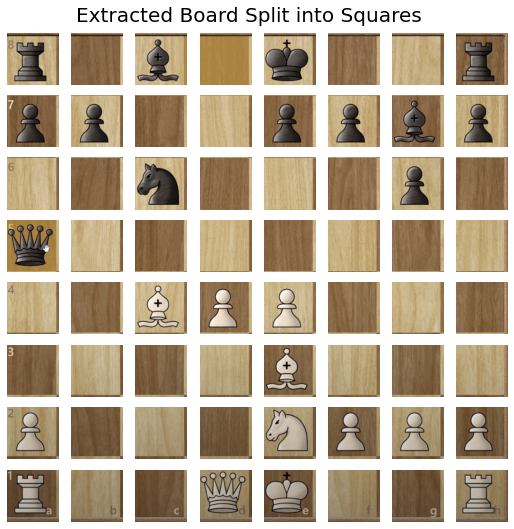

In [6]:
sq_fnames = sorted(os.listdir(square_path))

for _i, _fn in enumerate(sq_fnames):
    plt.subplot(8,8,_i+1)
    _im = Image.open(os.path.join(square_path, _fn))
    plt.imshow(_im)
    _im.close()
    plt.gca().set_axis_off()
plt.gcf().set_size_inches(9,9)
plt.suptitle('Extracted Board Split into Squares', fontsize = 20, y=0.92)
plt.show()



<h3> 3. Piece Identification</h3>

Next, pieces are identified from squares.

In [7]:
piece_model_dir = 'data/model/piece-final_weight'
piece_model_weight_fname = 'cnn_pieces_all_data_cohen.h5' #Using the model trained on all available data - no validation. The model with training/validation split is presented in Part3b (training accuracy of 99%, validation accuracy of 98%). I use this model here in order to utilize all data available.
tf_load_model_kwargs = {'custom_objects': tfa.metrics.CohenKappa(13)}
piece_classifier = Piece_Classification(piece_model_dir, piece_model_weight_fname)

square_size = 80   
image_size = [square_size, square_size]

y_piece_pred = piece_classifier.predict(square_path, image_size, tf_load_model_kwargs=tf_load_model_kwargs)

2021-12-23 15:09:43.720097: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-23 15:09:43.720330: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1
Prediction Image Count:64


2021-12-23 15:09:43.978986: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-12-23 15:09:44.015935: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


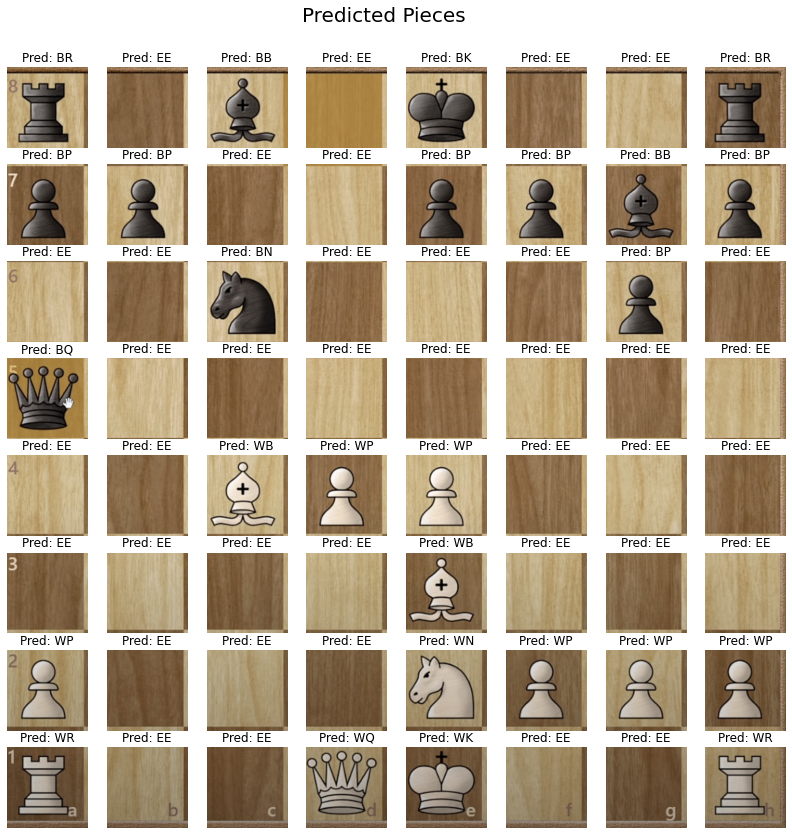

In [8]:
label_dict_csv_full_path = 'data/model/piece-train/chess_dict_all_EBW.csv'
label_dict = list(pd.read_csv(label_dict_csv_full_path, header=None).iloc[:,0])

piece_pred_ind = y_piece_pred.argmax(axis=1)
piece_pred_str = [label_dict[_] for _ in piece_pred_ind]

for _i, _fn in enumerate(sq_fnames):
    plt.subplot(8,8,_i+1)
    _im = Image.open(os.path.join(square_path, _fn))
    plt.imshow(_im)
    _im.close()
    plt.gca().set_axis_off()
    plt.gca().set_title('Pred: {0}'.format(piece_pred_str[_i]))
plt.gcf().set_size_inches(14,14)
plt.suptitle('Predicted Pieces', fontsize = 20, y=0.94)
plt.show()

<li>The model is a simple convolutional neural network that I implemented in Tensorflow.  
<li>As you can see, the model was able to capture all pieces correctly. This is not always the case. Piece Identification seems to be impacted by some factors such as satisfactory capture of squares and image quality.
<li>With hopes of improving the prediction, this model used all available data at training stage. Get-Chess-Board Part 3b demonstrates models trained with proper training-validation splits showing 99% training and 98% validation accuracy.

<h3> 4. Create FEN with Piece Placement</h3>

In this step, we are going to use the prediction data to create a piece placement string and embed that in an FEN - Forsyth-Edwards Notation. (https://en.wikipedia.org/wiki/Forsyth–Edwards_Notation; https://www.chessclub.com/help/PGN-spec - see 16.1: FEN)

An FEN is a 'space-separated' single ASII text line that defines the state of a chess game. It is made of six text blocks that represent: piece placement (a8->h1, grouped by rows); active color; castling availability; en passant target square; half-move clock; full move number.

For this analysis, the focus will be on piece placement although some other information could also be derived from piece placement (some cases of castling, en passant availability, ..) or screenshot (active color, en passant, ...) I will not attempt to do that here.

For piece placement, the analysis will also assume that White is always playing from the bottom of the screen. A way forward to get a better handle in direction here could lie in: looking at the placement of black&white pieces and running a binary classification; attempting to pick up a move history and deduce direction, or getting the neural network to recognize the letters and numbers on/around the chess board. For a left to right game, one can always make sure to rotate the board such that a black square is on the bottom-left and reduce to problem to one we could already solve. 

In [9]:
FEN_dict = {'EE':'.', 'WP':'P', 'WR':'R', 'WN':'N', 'WB':'B', 'WQ':'Q', 'WK':'K', 'BP':'p', 'BR':'r', 'BN':'n', 'BB':'b', 'BQ':'q', 'BK':'k'}

piece_pred_fen = [FEN_dict[_] for _ in piece_pred_str]

piece_pred_fen_disp = [''.join(piece_pred_fen[r*8:r*8+8]) for r in range(8)]

for _ in piece_pred_fen_disp:
    print(_)

r.b.k..r
pp..ppbp
..n...p.
q.......
..BPP...
....B...
P...NPPP
R..QK..R


Above is a simple text representation of the board state.
Now let's construct an FEN.

In [10]:
fen = ''
fen_piece_placement = gcb_utils.get_fen_from_labeled_pred(piece_pred_fen, rows=8, cols=8)
#fen_piece_placement = fen_piece_placement[::-1] #Uncomment if Black is playing from below instead.
#Rest of the FEN text blocks can be adjusted once we get to an analysis board
fen_active_color = 'w'      
fen_castling_avail = 'KQkq' 
fen_en_passant_target = '-'
fen_half_move_clock = str(0)
fen_full_move_num = str(1)

fen = ' '.join([fen_piece_placement, fen_active_color, fen_castling_avail, fen_en_passant_target, fen_half_move_clock, fen_full_move_num])
print(fen)

r1b1k2r/pp2ppbp/2n3p1/q7/2BPP3/4B3/P3NPPP/R2QK2R w KQkq - 0 1


<li>Above is the FEN. Please note that the comment about Black playing from below stands. See the first comment in the cell above.
    
<li>Below, I construct a particular url to the lichess.com analysis board.

In [11]:
lichess_head = ['https:/','lichess.org']
lichess_analysis_fen = 'editor?fen='+fen.replace('/','%2F').replace(' ', '+')
lichess_fen_url = '/'.join([*lichess_head,lichess_analysis_fen])
print(lichess_fen_url)

https://lichess.org/editor?fen=r1b1k2r%2Fpp2ppbp%2F2n3p1%2Fq7%2F2BPP3%2F4B3%2FP3NPPP%2FR2QK2R+w+KQkq+-+0+1


<li> Clicking on the line will open an Analysis Board on lichess as shown below:  </li> 

![Alt_text](z_markdown_jpgs/LichessAnalysisScreenShot2021-12-21at3.38.30PM.png)
    
<li>From here, one can make any changes on the screen (active player, castling availability etc...) and continue analysis.
<li>As an alternative clicking the above link, one can run the following cell to go directly to the analysis board.

In [12]:
import webbrowser as wb
wb.open(lichess_fen_url)

True